In [3]:
import pandas as pd

# Define the path to your dataset
file_path = "data/train_FD001.txt"

# Load the data with proper settings:
# - sep=' ' because the data is space-delimited
# - header=None because there is no header in the text file
# - engine data has trailing whitespace so we use delim_whitespace=True for better handling
df = pd.read_csv(file_path, sep=r'\s+', header=None)

# Drop any completely empty columns (some are due to spacing in the text file)
df.dropna(axis=1, how='all', inplace=True)

# Assign proper column names
df.columns = [
    'unit',                # Engine unit number
    'time_in_cycles',      # Time cycle
    'operational_setting_1',
    'operational_setting_2',
    'operational_setting_3'
] + [f'sensor_{i}' for i in range(1, df.shape[1] - 5 + 1)]  # Add dynamic sensor columns


In [4]:
print(df.shape)      # Show rows and columns
print(df.head())     # Show first 5 rows


(20631, 26)
   unit  time_in_cycles  operational_setting_1  operational_setting_2  \
0     1               1                -0.0007                -0.0004   
1     1               2                 0.0019                -0.0003   
2     1               3                -0.0043                 0.0003   
3     1               4                 0.0007                 0.0000   
4     1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0                  100.0    518.67    641.82   1589.70   1400.60     14.62   
1                  100.0    518.67    642.15   1591.82   1403.14     14.62   
2                  100.0    518.67    642.35   1587.99   1404.20     14.62   
3                  100.0    518.67    642.35   1582.79   1401.87     14.62   
4                  100.0    518.67    642.37   1582.85   1406.22     14.62   

   ...  sensor_12  sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  \
0  .

In [5]:
# Step 1: Find the max cycle for each engine — this is when the engine failed
rul_lookup = df.groupby('unit')['time_in_cycles'].max().reset_index()
rul_lookup.columns = ['unit', 'max_cycle']  # Rename for clarity

# Step 2: Merge the max_cycle info back into the main DataFrame
df = df.merge(rul_lookup, on='unit', how='left')

# Step 3: Calculate RUL for each row: max_cycle - current_cycle
df['RUL'] = df['max_cycle'] - df['time_in_cycles']

# Optional: Clean up the now-unnecessary 'max_cycle' column
df.drop(columns=['max_cycle'], inplace=True)

# Step 4: Display a few rows
print(df[['unit', 'time_in_cycles', 'RUL']].head(10))


   unit  time_in_cycles  RUL
0     1               1  191
1     1               2  190
2     1               3  189
3     1               4  188
4     1               5  187
5     1               6  186
6     1               7  185
7     1               8  184
8     1               9  183
9     1              10  182


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Select input features (drop non-predictive columns)
feature_cols = [col for col in df.columns if col not in ['unit', 'time_in_cycles', 'RUL']]

# Step 2: Define feature matrix X and target vector y
X = df[feature_cols]
y = df['RUL']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate performance using RMSE and R²
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression → RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Linear Regression → RMSE: 44.34
R²: 0.57


In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Initialize and train XGBoost
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 2: Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb) ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost → RMSE: {rmse_xgb:.2f}")
print(f"XGBoost → R²: {r2_xgb:.2f}")


XGBoost → RMSE: 41.36
XGBoost → R²: 0.63


In [11]:
# 1. Select numeric features to apply engineering (exclude target and IDs)
sensor_features = [col for col in df.columns if col not in ['unit', 'time_in_cycles', 'RUL']]

# 2. Sort the data correctly
df = df.sort_values(by=['unit', 'time_in_cycles'])

# 3. Apply rolling average and delta per engine
for col in sensor_features:
    df[f'{col}_roll3'] = df.groupby('unit')[col].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
    df[f'{col}_diff'] = df.groupby('unit')[col].diff().fillna(0)


In [12]:
# Define new set of feature columns (exclude ID, time, and target)
engineered_cols = [col for col in df.columns if col not in ['unit', 'time_in_cycles', 'RUL']]
X = df[engineered_cols]
y = df['RUL']


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_eng = xgb_model.predict(X_test)
rmse_eng = mean_squared_error(y_test, y_pred_eng) ** 0.5
r2_eng = r2_score(y_test, y_pred_eng)

print(f"XGBoost + Engineered Features → RMSE: {rmse_eng:.2f}")
print(f"XGBoost + Engineered Features → R²: {r2_eng:.2f}")


XGBoost + Engineered Features → RMSE: 39.47
XGBoost + Engineered Features → R²: 0.66


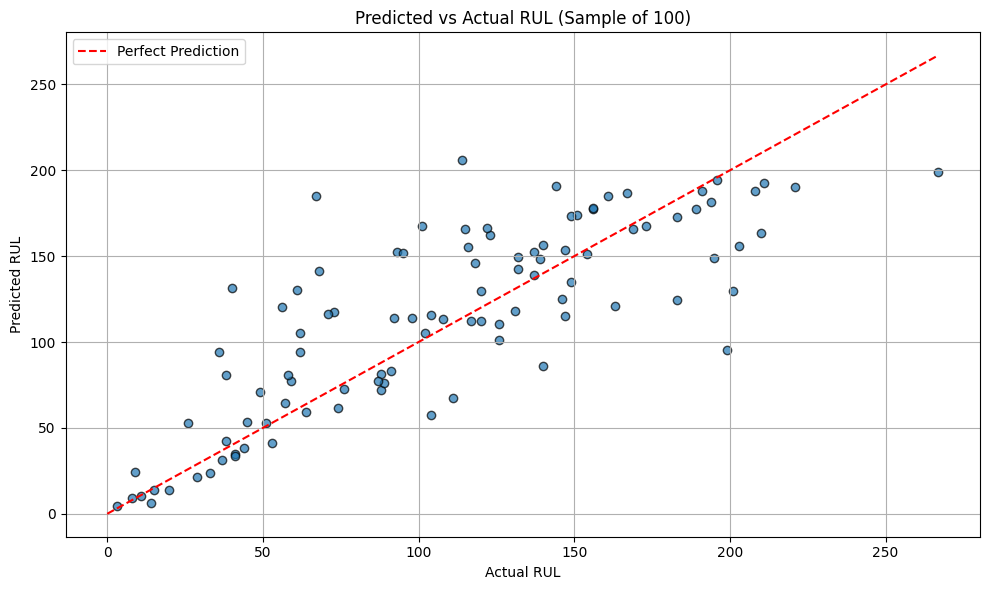

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Sample 100 random predictions to keep the plot readable
np.random.seed(42)
sample_indices = np.random.choice(len(y_test), size=100, replace=False)

# Get corresponding actual and predicted values
sample_actual = y_test.iloc[sample_indices].values
sample_predicted = y_pred_eng[sample_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(sample_actual, sample_predicted, alpha=0.7, edgecolors='k')
plt.plot([0, max(sample_actual)], [0, max(sample_actual)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Predicted vs Actual RUL (Sample of 100)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


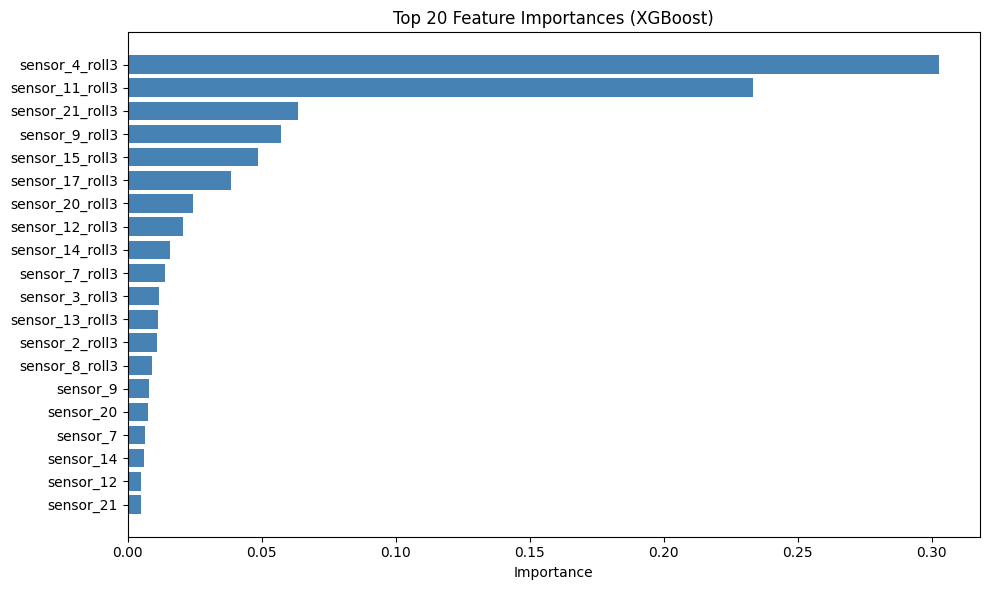

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances and map them to column names
importances = xgb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for sorting and plotting
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)  # top 20

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [17]:
import joblib

# Save the model
joblib.dump(xgb_model, 'xgb_rul_model.pkl')

# Later... Load the model
loaded_model = joblib.load('xgb_rul_model.pkl')

# Predict with loaded model
preds = loaded_model.predict(X_test)


In [18]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

# Load trained model
model = joblib.load('xgb_rul_model.pkl')

# Initialize Flask app
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Parse input JSON into a DataFrame
        input_data = request.get_json()
        input_df = pd.DataFrame([input_data])  # wrap dict in list for 1-row DataFrame

        # (Optional) Feature engineering must match training setup
        # input_df = preprocess(input_df)  # if needed

        # Predict
        prediction = model.predict(input_df)[0]
        return jsonify({'RUL_Prediction': round(float(prediction), 2)})
    
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True)


ModuleNotFoundError: No module named 'flask'